## Objective:

Train the Attention-LSTM Hybrid model on the Broadcom dataset from yahoo finance. The process flow is as follows:

1. Load last 5 years worth of stock prices.

2. Stationarize the stock prices through differencing.

3. Normalize the differences using Z-norm or Min-Max.

4. Split dataset for 5 fold Cross Validation.

5. Select Hyper-parameters that work best for 1 time step prediction

In [ ]:
!pip install pandas
!pip install yfinance
!pip install yahoofinancials

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from yahoofinancials import YahooFinancials
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
import math
from sklearn.metrics import mean_squared_error
import itertools

In [3]:
# setting variables
SEED = 42
DEVICE = "mps"
WINDOW_SIZE = 30

## Dataset Loading

### Functions

In [4]:
def load_and_create_features_by_date(symbol: str, start_date: str, end_date: str, normalization: str = 'minmax',
                                       short_window: int = 20, long_window: int = 50, plot: bool = False):
    """
    Loads stock data from Yahoo Finance for a specified date range, saves the raw closing price and date,
    normalizes the closing price, and computes additional features.

    Parameters:
        symbol (str): Stock ticker symbol.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        normalization (str): Type of normalization for the closing price. Options: 'minmax' or 'zscore'.
                             Default is 'minmax'.
        short_window (int): Window size for short-term moving average and volatility. Default is 20.
        long_window (int): Window size for long-term moving average. Default is 50.
        plot (bool): If True, plots the normalized closing price.

    Returns:
        np.ndarray: Array containing the features with the following columns:
                    ['Date', 'Open', 'High', 'Low', 'Close', 'Price_Diff',
                     'Short_Term_Diff', 'Long_Term_Diff', 'Short_Term_SMA',
                     'Long_Term_SMA', 'Volatility', 'Volume', 'Raw_Close'].
        dict: Normalization parameters used for the 'Close' column.
    """
    try:
        ticker = yf.Ticker(symbol)
        df = ticker.history(start=start_date, end=end_date)
    except Exception as e:
        raise ValueError(f"Error fetching data: {e}")

    # Reset index to preserve Date as a column
    df.reset_index(inplace=True)

    # Ensure required columns are present
    required_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("Missing required columns in the fetched stock data.")

    # Save the raw closing price before normalization
    df['Raw_Close'] = df['Close']

    # Normalize the 'Close' column
    if normalization.lower() == 'minmax':
        close_min = df['Close'].min()
        close_max = df['Close'].max()
        df['Close'] = (df['Close'] - close_min) / (close_max - close_min)
        norm_params = {'min': close_min, 'max': close_max}
    elif normalization.lower() == 'zscore':
        close_mean = df['Close'].mean()
        close_std = df['Close'].std()
        df['Close'] = (df['Close'] - close_mean) / close_std
        norm_params = {'mean': close_mean, 'std': close_std}
    else:
        raise ValueError("Normalization method not recognized. Use 'minmax' or 'zscore'.")

    if plot:
        df["Close"].plot(title=f"{symbol}'s Normalized Close Price")
        plt.xlabel("Date")
        plt.ylabel("Normalized Close Price")
        plt.show()

    # Compute additional features using the normalized closing price
    df['Price_Diff'] = df['Close'].diff()
    df['Short_Term_SMA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_Term_SMA'] = df['Close'].rolling(window=long_window).mean()
    df['Short_Term_Diff'] = df['Close'] - df['Short_Term_SMA']
    df['Long_Term_Diff'] = df['Close'] - df['Long_Term_SMA']
    df['Volatility'] = df['Close'].rolling(window=short_window).std()

    # Instead of dropping rows with NaN values, fill them appropriately
    df['Price_Diff'].fillna(0, inplace=True)
    df['Short_Term_SMA'].fillna(method='ffill', inplace=True)
    df['Long_Term_SMA'].fillna(method='ffill', inplace=True)
    df['Short_Term_Diff'].fillna(0, inplace=True)
    df['Long_Term_Diff'].fillna(0, inplace=True)
    df['Volatility'].fillna(method='ffill', inplace=True)

    # Order the columns, ensuring that the Date and Raw_Close are kept
    final_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Price_Diff',
                     'Short_Term_Diff', 'Long_Term_Diff', 'Short_Term_SMA',
                     'Long_Term_SMA', 'Volatility', 'Volume', 'Raw_Close']
    df_features = df[final_columns]
    df_features.to_csv("Dataset.csv")

    return df_features.values, norm_params


In [5]:
def create_training_windows(data: np.ndarray, window_size: int):
    """
    Creates training data by generating sliding windows of the dataset features.

    Parameters:
        data (np.ndarray): NumPy array of shape [n_samples, n_features] containing the features.
        window_size (int): Size of the sliding window (number of time steps).

    Returns:
        X (np.ndarray): Array of shape [n_samples - window_size, window_size, n_features] containing the input windows.
        Y (np.ndarray): Array of shape [n_samples - window_size,] containing the target values (normalized 'Close' price)
                        at the time step immediately following each window (from column index 3).
    """
    if not isinstance(data, np.ndarray):
        raise ValueError("Data should be a numpy array containing stock data values.")

    n_samples = data.shape[0]
    if n_samples <= window_size:
        raise ValueError("Dataset length must be greater than window_size.")

    X, Y = [], []

    # Column index for 'Close' is assumed to be 3 based on our column order.
    for i in range(window_size, n_samples):
        window = data[i - window_size:i, :]  # window of shape (window_size, n_features)
        target = data[i, 5]                  # Predict closing price diff at T
        X.append(window)
        Y.append(target)

    return np.array(X), np.array(Y)


### Loading Feature Numpy

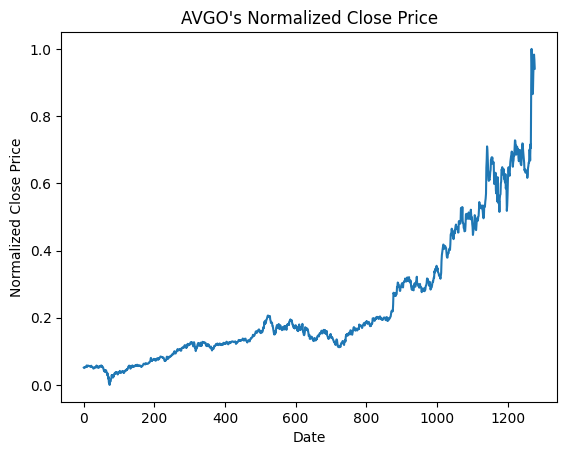

/var/folders/nc/67s_8rj55dl1xcbv0xbgf6yh0000gn/T/ipykernel_4424/1529472618.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price_Diff'].fillna(0, inplace=True)
/var/folders/nc/67s_8rj55dl1xcbv0xbgf6yh0000gn/T/ipykernel_4424/1529472618.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [87]:
# Loading Feature array
feature_array, norm_params = load_and_create_features_by_date("AVGO", "2019-12-02", "2024-12-31", normalization = "minmax", short_window = 30, long_window = 60, plot = True)

In [88]:
print("Shape of Feature Array: ", feature_array.shape)

Shape of Feature Array:  (1278, 13)


In [89]:
X, Y = create_training_windows(feature_array, WINDOW_SIZE)
print("Shape of Input Feature Array: ", X.shape)
print("Shape of GT Array: ", Y.shape)

Shape of Input Feature Array:  (1248, 30, 13)
Shape of GT Array:  (1248,)


## Train - Test Split and Dataloader

### Functions

In [9]:
class StockDataset(Dataset):
    def __init__(self, X, Y):
        """
        Initializes the dataset with feature windows and targets.

        Parameters:
            X (np.ndarray): Array of shape [n_samples, window_size, n_features]
            Y (np.ndarray): Array of shape [n_samples,] containing the target closing price.
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

### Process

In [10]:
# Creating X with just price diff
X_diff = np.expand_dims(X[:, :, 5], -1).astype("float")
X_diff.shape

(1248, 30, 1)

In [11]:
print(np.min(X_diff), np.max(X_diff))

-0.07056421009339775 0.18751984304389413


In [12]:
dataset = StockDataset(X_diff, Y)

In [13]:
# Split the dataset: first 800 for Cross Validation, the rest for Testing
cv_indices = list(range(800))
test_indices = list(range(800, len(dataset)))

In [14]:
cv_dataset = Subset(dataset, cv_indices)
test_dataset = Subset(dataset, test_indices)

In [15]:
print(f"CV dataset size: {len(cv_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

CV dataset size: 800
Test dataset size: 448


## Model and Cross Validation

### Functions

In [16]:
# Define the attention module
class Attention(nn.Module):
    def __init__(self, hidden_size):
        """
        Function to initialize an additive Attention layer

        Parameters:
            hidden_size: Dimension of the hidden size
        """
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        # Feed forward layers to create the weight vectors
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)
        # Initializing weights
        self.initialize_weights()
    def forward(self, lstm_out):
        """
        Function to run forward pass with attention layer

        Parameters:
            lstm_out: Output from the lstm
        Returns:
            context_vector: Shape = (batch_size, hidden_size)
            attention_weights: Shape = (batch_size, seq_length, 1)
        """
        # lstm_out shape: (batch_size, seq_length, hidden_size)
        # Calculate attention scores
        scores = self.Va(torch.tanh(self.Wa(lstm_out) + self.Ua(lstm_out)))
        attention_weights = torch.softmax(scores, dim=1)  # Shape: (batch_size, seq_length, 1)

        # Weighted sum of the LSTM outputs
        context_vector = torch.bmm(attention_weights.permute(0, 2, 1), lstm_out)  # Shape: (batch_size, 1, hidden_size)
        context_vector = context_vector.squeeze(1)  # Shape: (batch_size, hidden_size)

        return context_vector, attention_weights

    def initialize_weights(self):
        """
        Function to initialize the weights of the Attention Layers
        """
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_uniform_(param.data)  # Kaiming uniform initialization
            elif 'bias' in name:
                nn.init.zeros_(param.data)  # Initialize biases to zero

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0, bidirectional=False):
        """
        Initializes the LSTM model with an attention mechanism.

        Parameters:
            input_size (int): Dimension of the input features.
            hidden_size (int): Dimension of the LSTM hidden layer.
            num_layers (int): Number of LSTM layers.
            dropout (float): Dropout probability applied between LSTM layers (only if num_layers > 1).
            bidirectional (bool): If True, uses a bidirectional LSTM.
        """
        super(LSTMModel, self).__init__()

        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        # Adjust hidden dimension for attention and output layer if bidirectional
        attn_input_dim = hidden_size * self.num_directions

        self.attention = Attention(attn_input_dim)
        self.fc = nn.Linear(attn_input_dim, 1)  # Output layer for 1D output

        # Initialize weights using Kaiming uniform initialization
        self.initialize_weights()

    def forward(self, x):
        """
        Forward pass of the model.

        Parameters:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
            Tensor: Output predictions of shape (batch_size, 1)
        """
        # LSTM output shape: (batch_size, seq_length, hidden_size * num_directions)
        lstm_out, _ = self.lstm(x)
        # Apply attention mechanism to get a context vector (batch_size, attn_input_dim)
        context_vector, attention_weights = self.attention(lstm_out)
        output = self.fc(context_vector)  # Shape: (batch_size, 1)
        return output

    def initialize_weights(self):
        """
        Initialize weights of the LSTM layers and fully connected layer using Kaiming uniform initialization.
        """
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_uniform_(param.data, nonlinearity='relu')
            elif 'bias' in name:
                nn.init.zeros_(param.data)


In [25]:
# Function to train on one fold
def train_one_fold(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, clip_value):
    model.to(device)
    criterion = MAPELoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            #torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
        #scheduler.step()

    # Evaluation on the validation set
    model.eval()
    preds = []
    actuals = []
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            val_loss += loss.item()
            preds.extend(outputs.cpu().numpy())
            actuals.extend(batch_Y.cpu().numpy())
    mape = val_loss / len(val_loader)
    return mape

In [26]:
class MAPELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super(MAPELoss, self).__init__()
        self.eps = eps  # To avoid division by zero

    def forward(self, pred, target):
        # Compute absolute percentage error
        ape = torch.abs((target - pred) / (target + self.eps))
        return torch.mean(ape)

### Process

In [27]:
hyperparams_grid = {
    'num_layers': [1, 2],
    'hidden_size': [2, 3, 4],
    'batch_size': [16, 32],
    'learning_rate': [1e-3, 1e-4],
    'optimizer': ['adam', 'sgd'],
    'dropout': [0.0, 0.2],
}

In [28]:
# Combination of hyperparameters
param_combinations = list(itertools.product(
    hyperparams_grid['num_layers'],
    hyperparams_grid['hidden_size'],
    hyperparams_grid['batch_size'],
    hyperparams_grid['learning_rate'],
    hyperparams_grid['optimizer'],
    hyperparams_grid['dropout']
))


In [29]:
# Traning configuration
num_epochs = 2
clip_value = 5.0

In [30]:
# Setting up k-fold cross validation
kf = KFold(n_splits = 5, shuffle = True, random_state = SEED)

In [31]:
Results = []
for params in param_combinations:
    num_layers, hidden_size, batch_size, learning_rate, opt_choice, dropout = params
    # RMSE across the fold
    fold_rmse = []

    # Run cross validation
    for train_idx, val_idx in kf.split(X):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Build model with the current hyperparameters
        input_size = X_diff.shape[2]  # Number of features per time step
        model = LSTMModel(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout)

        # Choose optimizer
        if opt_choice == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif opt_choice == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

        # Cosine annealing scheduler -- NOT USING SCHEDULER for Cross Validation
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        # Train for this fold and get RMSE on validation set
        rmse = train_one_fold(model, train_loader, val_loader, optimizer, scheduler,
                              num_epochs, DEVICE, clip_value)
        fold_rmse.append(rmse)

    avg_rmse = np.mean(fold_rmse)
    Results.append((params, avg_rmse))
    #print(f"Params: {params}, Average RMSE: {avg_rmse:.4f}")

# Determine and print the best hyperparameter combination
best_params, best_rmse = min(Results, key=lambda x: x[1])
print(f"\nBest hyperparameters: {best_params} with Average RMSE: {best_rmse:.4f}")


Best hyperparameters: (2, 3, 32, 0.0001, 'adam', 0.0) with Average RMSE: 1.3151


In [32]:
# Determine and print the best hyperparameter combination
best_params, best_rmse = min(Results, key=lambda x: x[1])
print(f"\nBest hyperparameters: {best_params} with Average RMSE: {best_rmse:.4f}")


Best hyperparameters: (2, 3, 32, 0.0001, 'adam', 0.0) with Average RMSE: 1.3151


## Training Full Model

### Functions

In [70]:
def train_full_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, clip_value, device):
    """
    Train the model on the training set and monitor validation loss.

    Parameters:
        model: The PyTorch model.
        train_loader: DataLoader for the training data.
        val_loader: DataLoader for the validation data.
        optimizer: Optimizer for training.
        scheduler: Learning rate scheduler.
        num_epochs: Number of training epochs.
        clip_value: Gradient clipping threshold.
        device: Torch device.

    Returns:
        train_losses: List of training MSE loss per epoch.
        val_losses: List of validation MSE loss per epoch.
    """
    criterion = MAPELoss()
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            epoch_train_losses.append(loss.item())
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(avg_train_loss)

        # Evaluation on the validation set
        model.eval()
        preds = []
        actuals = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_Y in val_loader:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                val_loss += loss.item()
                preds.extend(outputs.cpu().numpy())
                actuals.extend(batch_Y.cpu().numpy())
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
    
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val MAPE = {val_loss:.4f}")

    return train_losses, val_losses, model

### Process
num, hiddensize, batchsize, lr, optimi, dropout
2, 3, 32, 0.0001, 'adam', 0.0

In [71]:
best_params = {
    'num_layers': 2,
    'hidden_size': 3,
    'dropout': 0.0,
    'batch_size': 32,
    'learning_rate': 1e-4,
    'optimizer': 'adam',  # Options: 'adam' or 'sgd'
}

In [72]:
# Training epoch and clip
num_epochs = 30
clip_value = 5.0

In [73]:
# splitting CV datset into 600 - 200 train - val split
train_indices = list(range(600))
val_indices = list(range(600, 800))

In [74]:
# Dataset creation
cv_train_dataset = Subset(cv_dataset, train_indices)
cv_val_dataset = Subset(cv_dataset, val_indices)
# Loader Creation
train_loader = DataLoader(cv_train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(cv_val_dataset, batch_size=best_params['batch_size'], shuffle=False)

In [75]:
# Input size should match the number of features in your data (assume 11 as defined earlier)
input_size = 1

# Initialize model with best parameters
model = LSTMModel(
    input_size=input_size,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
)

In [76]:
#Initializing Optimizer
# Select optimizer based on best_params
if best_params['optimizer'] == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'], momentum=0.9)
else:
    raise ValueError("Unsupported optimizer choice.")


In [77]:
# Cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [78]:
# Train the model and capture training and validation losses
train_losses, val_losses, model = train_full_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, clip_value, DEVICE)

Epoch 1/30: Train Loss = 1.7146, Val MAPE = 1.3714
Epoch 2/30: Train Loss = 1.8804, Val MAPE = 1.3610
Epoch 3/30: Train Loss = 1.8664, Val MAPE = 1.3434
Epoch 4/30: Train Loss = 1.6165, Val MAPE = 1.4195
Epoch 5/30: Train Loss = 1.9178, Val MAPE = 1.4136
Epoch 6/30: Train Loss = 1.3505, Val MAPE = 1.3832
Epoch 7/30: Train Loss = 1.5558, Val MAPE = 1.3018
Epoch 8/30: Train Loss = 1.3986, Val MAPE = 1.2860
Epoch 9/30: Train Loss = 1.4059, Val MAPE = 1.2882
Epoch 10/30: Train Loss = 1.3991, Val MAPE = 1.3772
Epoch 11/30: Train Loss = 1.4985, Val MAPE = 1.2591
Epoch 12/30: Train Loss = 1.3572, Val MAPE = 1.2654
Epoch 13/30: Train Loss = 1.3707, Val MAPE = 1.2537
Epoch 14/30: Train Loss = 1.5370, Val MAPE = 1.2498
Epoch 15/30: Train Loss = 1.4268, Val MAPE = 1.3238
Epoch 16/30: Train Loss = 1.3465, Val MAPE = 1.3049
Epoch 17/30: Train Loss = 1.3130, Val MAPE = 1.2617
Epoch 18/30: Train Loss = 1.2862, Val MAPE = 1.2398
Epoch 19/30: Train Loss = 1.2654, Val MAPE = 1.2690
Epoch 20/30: Train Lo

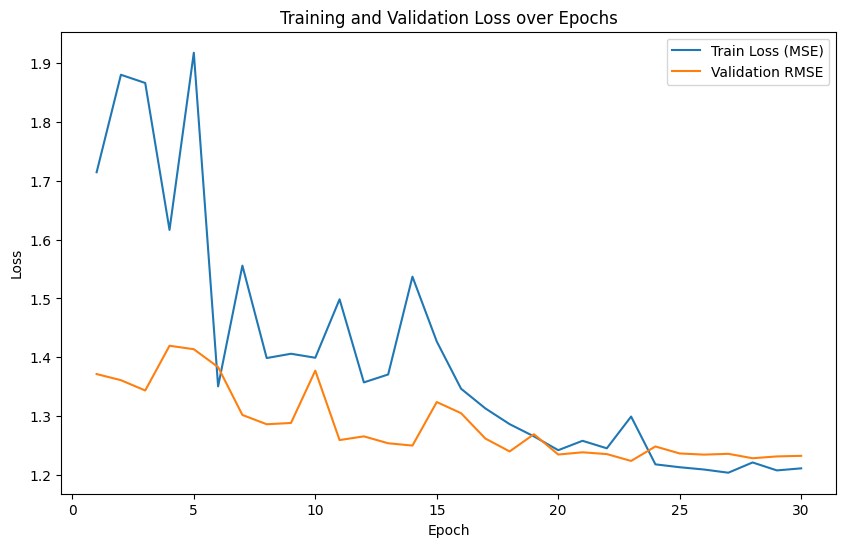

In [79]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss (MSE)')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation RMSE')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

## Random Walk Comparison on Test Set

### Functions

In [80]:
def evaluate_random_walk_using_Y(Y_array):
    """
    Evaluate a random walk baseline using the target closing prices directly.

    Parameters:
        Y_array (np.ndarray): 1D numpy array containing the actual normalized closing prices from the test set.

    Returns:
        rmse: RMSE computed between the random walk predictions and the actual values.
        preds: Random walk predictions.
        actuals: Actual Y values (excluding the first sample).
    """
    # For a random walk baseline, the prediction at time t is simply the closing price at time t-1.
    # Therefore, shift Y by one.
    preds = Y_array[:-1]        # Predictions: previous closing prices
    actuals = Y_array[1:]        # Actual values for time t (starting from the second sample)

    rmse = math.sqrt(mean_squared_error(actuals, preds))
    return rmse, preds, actuals


In [81]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the trained model on the test set.

    Parameters:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test dataset.
        device: Torch device (cpu or cuda).

    Returns:
        rmse: Root Mean Squared Error on the test set.
        preds: Numpy array of model predictions.
        actuals: Numpy array of actual target values.
    """
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs = model(batch_X)
            preds.extend(outputs.cpu().numpy())
            actuals.extend(batch_Y.cpu().numpy())

    rmse = math.sqrt(mean_squared_error(actuals, preds))
    return rmse, np.array(preds), np.array(actuals)


In [82]:
def unnormalize(values, method='minmax', params=None):
    """
    Unnormalizes the given values based on the specified normalization method.

    Parameters:
        values (np.ndarray or float): Normalized values.
        method (str): The normalization method used. Options: 'minmax' or 'zscore'.
        params (dict): Parameters used during normalization.
                       For 'minmax', provide {'min': value, 'max': value}.
                       For 'zscore', provide {'mean': value, 'std': value}.

    Returns:
        np.ndarray or float: Unnormalized values.

    Raises:
        ValueError: If required parameters are missing.
    """
    if params is None:
        raise ValueError("Normalization parameters must be provided in 'params'.")

    if method.lower() == 'minmax':
        if 'min' not in params or 'max' not in params:
            raise ValueError("For minmax, 'params' must contain 'min' and 'max'.")
        return values * (params['max'] - params['min']) + params['min']

    elif method.lower() == 'zscore':
        if 'mean' not in params or 'std' not in params:
            raise ValueError("For zscore, 'params' must contain 'mean' and 'std'.")
        return values * params['std'] + params['mean']

    else:
        raise ValueError("Unsupported normalization method. Choose 'minmax' or 'zscore'.")


### Process

In [83]:
# The test loader
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [84]:
all_Y = []
for _, batch_Y in test_loader:
    # batch_Y is a tensor; convert it to numpy and extend the list.
    all_Y.extend(batch_Y.cpu().numpy())

In [85]:
Y_test = np.array(all_Y)

In [86]:
rw_rmse, rw_preds, rw_actuals = evaluate_random_walk_using_Y(Y_test)
print(f"Random Walk Baseline RMSE (using Y): {rw_rmse:.4f}")

Random Walk Baseline RMSE (using Y): 0.0243


In [91]:
stock_price = feature_array[:, -1]
print(stock_price)

[26.702648162841797 26.341711044311523 26.616710662841797 ...
 245.36000061035156 241.75 235.5800018310547]


In [92]:
rw_actuals_renorm = unnormalize(rw_actuals, method = "minmax", params = norm_params)
rw_preds_renorm = unnormalize(rw_preds, method = "minmax", params = norm_params)

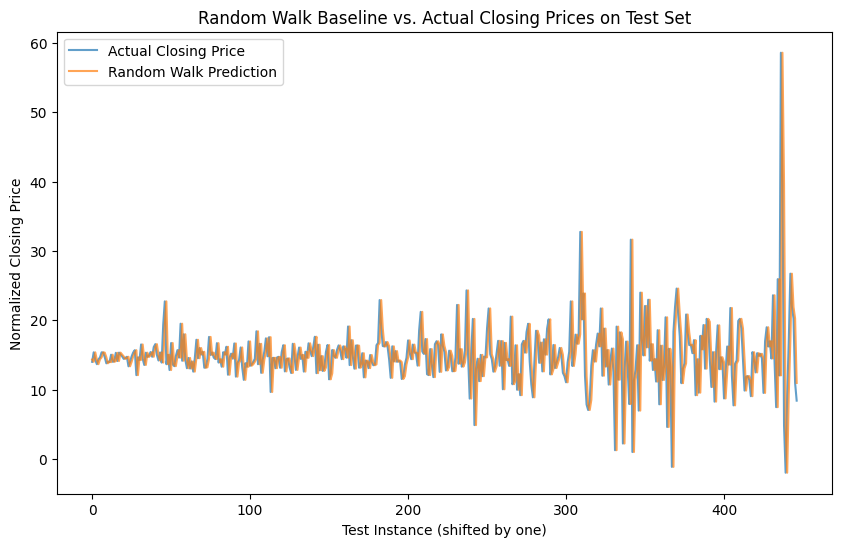

In [93]:
# Plot the actual closing prices and random walk predictions
plt.figure(figsize=(10, 6))
plt.plot(rw_actuals_renorm, label="Actual Closing Price", alpha=0.7)
plt.plot(rw_preds_renorm, label="Random Walk Prediction", alpha=0.7)
plt.xlabel("Test Instance (shifted by one)")
plt.ylabel("Normalized Closing Price")
plt.title("Random Walk Baseline vs. Actual Closing Prices on Test Set")
plt.legend()
plt.show()

**Trained LSTM Model**

In [94]:
test_rmse, test_preds, test_actuals = evaluate_model(model, test_loader, DEVICE)
print(f"Test Set RMSE: {test_rmse:.4f}")

Test Set RMSE: 0.0187


In [95]:
test_actuals_renorm = unnormalize(test_actuals, method = "minmax", params = norm_params)
test_preds_renorm = unnormalize(test_preds, method = "minmax", params = norm_params)

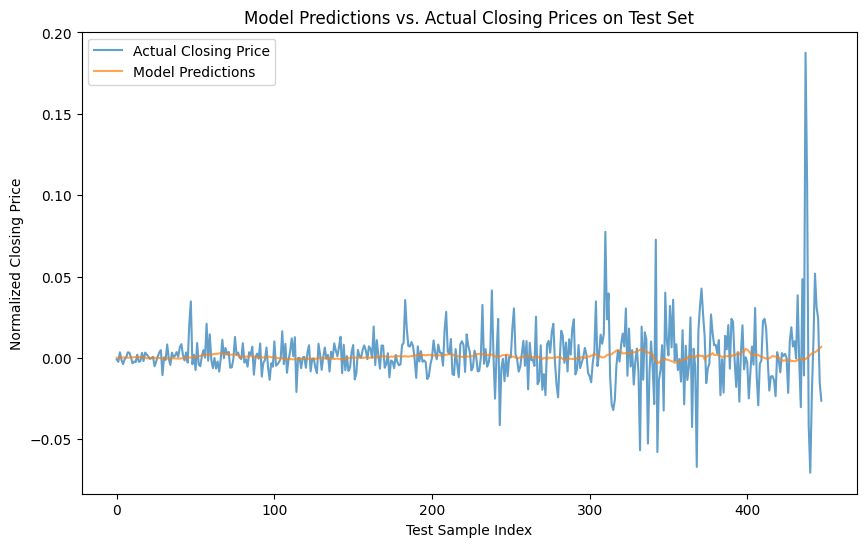

In [96]:
# Plotting model predictions vs. actual closing prices
plt.figure(figsize=(10,6))
plt.plot(test_actuals, label="Actual Closing Price", alpha=0.7)
plt.plot(test_preds, label="Model Predictions", alpha=0.7)
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Closing Price")
plt.title("Model Predictions vs. Actual Closing Prices on Test Set")
plt.legend()
plt.show()

## Inference on full 5 years

In [ ]:
inference_loader = DataLoader(dataset,batch_size = 1, shuffle = False)

In [ ]:
counter1 = 29
gt, pred = [], []
for i, data in enumerate(inference_loader, 0):
    inputs, labels = data
    inputs = inputs.to("cuda")
    labels = labels.to("cuda")
    outputs = model(inputs)
    prediction = outputs.cpu().detach().numpy()

    # Predicted actual stock price = last known stock price + predicted price difference
    stock_price_predicted = stock_price[counter1] + prediction
    actual_stock_price = stock_price[counter1 + 1]
    counter1 += 1
    gt.append(actual_stock_price)
    pred.append(stock_price_predicted[0][0])

<ipython-input-168-814c1e96f9e9>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_price_predicted = stock_price[counter1] + prediction
<ipython-input-168-814c1e96f9e9>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_stock_price = stock_price[counter1 + 1]


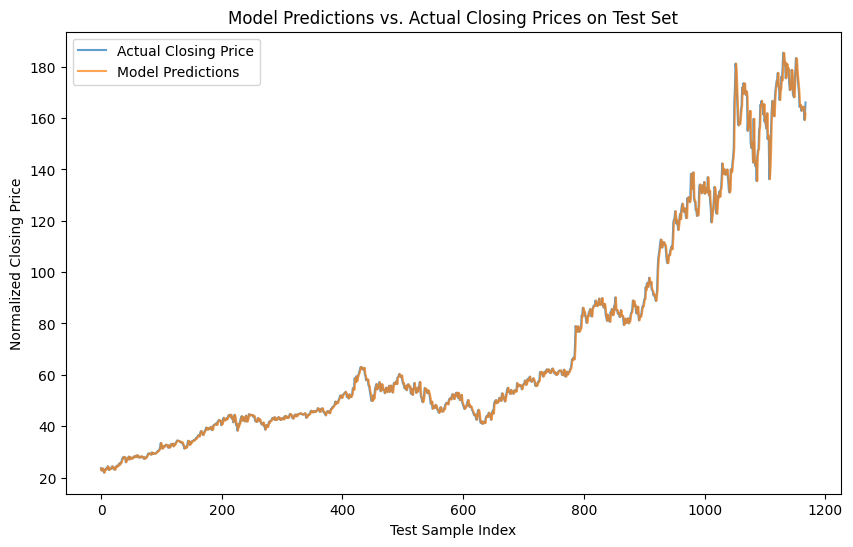

In [ ]:
# Plotting model predictions vs. actual closing prices
plt.figure(figsize=(10,6))
plt.plot(gt, label="Actual Closing Price", alpha=0.7)
plt.plot(pred, label="Model Predictions", alpha=0.7)
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Closing Price")
plt.title("Model Predictions vs. Actual Closing Prices on Test Set")
plt.legend()
plt.show()

In [ ]:
print(len(pred))

1168


In [ ]:
print(pred)

[22.946749, 23.627447, 22.72785, 22.802866, 23.473001, 22.802057, 21.863638, 22.951355, 22.859533, 23.378668, 23.700006, 23.371578, 24.368307, 23.979778, 22.927467, 23.153488, 23.383938, 23.323027, 23.638203, 24.28082, 24.313509, 23.6999, 23.231972, 23.536581, 22.990128, 24.148449, 24.008987, 24.603115, 24.260582, 24.423922, 24.897982, 25.389755, 24.99689, 25.714624, 25.60157, 26.31402, 27.326607, 27.27008, 27.993124, 28.031982, 27.837711, 27.812933, 25.93333, 26.507206, 26.84629, 27.431623, 27.671759, 28.137018, 27.00516, 27.965769, 27.765978, 27.379765, 27.547453, 27.419031, 27.630438, 28.150414, 27.893585, 28.137949, 28.434023, 27.928267, 28.503544, 28.675688, 28.491962, 27.76685, 28.103134, 27.987183, 27.769552, 27.891712, 28.285948, 28.037094, 27.988995, 27.620714, 27.274553, 27.889166, 27.413717, 27.547556, 27.837423, 28.252182, 28.651789, 29.290466, 29.393066, 29.359186, 29.071045, 29.19855, 28.901564, 29.758621, 29.38215, 29.2394, 29.462435, 29.31263, 29.363539, 29.329687, 29.4

In [ ]:
np.save("Predictions_5Y.npy", np.array(pred))